In [1]:
import pandas as pd
import re
import pickle
import datetime
import textdistance
import json
import numpy as np
import wikipedia as wiki
path_data= 'C:/root/Universita/project_dmdv/data/'




#some useful functions

#funzione per la sostituzione sulla base di una regex, la funzione nativa va in errore se il valore è null
def regex_replace(regex, sub, string):
    if pd.isnull(string):
        return None
    else:
        return re.sub(regex, sub, string)

#matching sulla base di una regex, la f nativa va in errore se il valore è mancante
def regex_match(regex, string, reverse = False):
    if pd.isnull(string):
        return None
    else:
        return re.match(regex, string)
    
#is_winner
def get_winner(string):
    if string:
        return 'Winner'
    else:
        return 'Nominee'

#funzione per la sostituzione delle stringe contententi solo spazi
def replace_na_string(string):
    str_out = string
    if pd.notnull(string):
        if string.replace(' ', '') == '':
            str_out = None
        else:
            str_out = string.upper()
    return str_out

#estrazione sottostringa (se pd.NoneType, lo slicing di python base va in errore)
def substring(string, start, end):
    str_out = None
    if pd.notnull(string):
        str_out = string[start:end]
    return str_out

#conversione in tipo data ed eventuale pulizia in caso di errori (es. 0008 -> 2008, 20012 -> 2012, ecc)
def get_date(date):
    try:
        date_out = pd.to_datetime(date, format = "%Y-%m-%d")
    except:
        date_list = date.split('-')
        if date_list[0][:2] == '10':
            date_list[0] = '19' + date_list[0][-2:]
        elif date_list[0][:2] == '00':
            date_list[0] = '20' + date_list[0][-2:]
        elif len(date_list[0]) > 4:
            date_list[0] = date_list[0][:2] + date_list[0][-2:]
        date_out = pd.to_datetime('-'.join(date_list), format = "%Y-%m-%d")
    return date_out

# IMPORT

### Awards

In [2]:
award_movies = pd.read_pickle(path_data + 'awards/integrated/award_movies_final.df')
award_movies['source'] = 'movies'
award_movies.columns = ['award', 'award_id', 'award_type', 'is_winner', 'person', 'title_id', 'year', 'source']
award_movies.head()

,award,award_id,award_type,is_winner,person,title_id,year,source
24728,COSTUME DESIGN,aw-9999,oscar award,Nominee,[Mayes C. Rubeo],m-362956,2019.0,movies
24727,COSTUME DESIGN,aw-9998,oscar award,Nominee,[Sandy Powell and Christopher Peterson],m-269036,2019.0,movies
34300,CINEMATOGRAPHY,aw-9997,oscar award,Nominee,[Robert Richardson],m-323567,2019.0,movies
24724,CINEMATOGRAPHY,aw-9996,oscar award,Winner,[Roger Deakins],m-376054,2019.0,movies
24721,CINEMATOGRAPHY,aw-9995,oscar award,Nominee,[Jarin Blaschke],m-353452,2019.0,movies


In [3]:
award_tvs = pd.read_pickle(path_data + 'awards/integrated/award_tvseries_final.df')
award_tvs['source'] = 'tv'
award_tvs.head()

,award,award_id,award_type,is_winner,person,title_id,year,source
67013,Television Series,aw-24537,golden globe,Winner,[],tv-25421,1961.0,tv
67002,Television Series,aw-24536,golden globe,Winner,[],tv-1479,1961.0,tv
66996,Actress In A Television Series,aw-24535,golden globe,Winner,[Donna Reed],tv-10204,1962.0,tv
66987,Actor In A Television Series,aw-24534,golden globe,Winner,[Richard Chamberlain],tv-16596,1962.0,tv
165323,Television Series - Comedy,aw-24533,golden globe,Winner,[],tv-440,1962.0,tv


In [4]:
#concatenazione premi cinema e premi televisivi
all_awards = pd.concat([award_tvs, award_movies])
all_awards.head()

,award,award_id,award_type,is_winner,person,title_id,year,source
67013,Television Series,aw-24537,golden globe,Winner,[],tv-25421,1961.0,tv
67002,Television Series,aw-24536,golden globe,Winner,[],tv-1479,1961.0,tv
66996,Actress In A Television Series,aw-24535,golden globe,Winner,[Donna Reed],tv-10204,1962.0,tv
66987,Actor In A Television Series,aw-24534,golden globe,Winner,[Richard Chamberlain],tv-16596,1962.0,tv
165323,Television Series - Comedy,aw-24533,golden globe,Winner,[],tv-440,1962.0,tv


In [5]:
#verticalizzo
awards = all_awards.copy()[
    ['award_id', 'person', 'title_id', 'source']
].explode('person')

#replace valori mancanti con None
awards['person'] = [replace_na_string(name) for name in awards['person']]
awards_noname = awards.copy()[(pd.isnull(awards['person'])) | (awards['person'] == 'N/A')]

#escludo quelli che non hanno una persona 
awards = awards.copy()[pd.notnull(awards['person'])]

#id temporaneo per riconoscere il record
awards['id'] = [i+1 for i in range(awards.shape[0])]
awards.head()

,award_id,person,title_id,source,id
66996,aw-24535,DONNA REED,tv-10204,tv,1
66987,aw-24534,RICHARD CHAMBERLAIN,tv-16596,tv,2
66981,aw-24532,ROD SERLING,tv-15712,tv,3
66962,aw-24530,DOROTHY LOUDON,tv-221,tv,4
66957,aw-24529,CAROLYN JONES,tv-916,tv,5


### People

In [6]:
people_original = pd.read_json(path_data + 'tmdb/json/tmdb_people.json')

In [7]:
people = people_original.copy()[['name', 'person_id', 'popularity', 'also_known_as']]
#lista unica con i nomi della persona
people['person'] = [x[0] + [x[1]] for x in zip(
    people['also_known_as'], people['name']
)]
people.head()

,name,person_id,popularity,also_known_as,person
387,George Lucas,p-1,13.601,"[George Walton Lucas Jr. , 乔治·卢卡斯, Джордж Лука...","[George Walton Lucas Jr. , 乔治·卢卡斯, Джордж Лука..."
389,Mark Hamill,p-2,24.227,"[Mark Hamil, Mark Richard Hamill, Марк Хэмилл,...","[Mark Hamil, Mark Richard Hamill, Марк Хэмилл,..."
391,Harrison Ford,p-3,11.438,"[Гаррісон Форд, Харрисон Форд, هاريسون فورد, 해...","[Гаррісон Форд, Харрисон Форд, هاريسون فورد, 해..."
393,Carrie Fisher,p-4,10.231,"[Carrie Frances Fisher , Кэрри Фишер, Кэрри Фр...","[Carrie Frances Fisher , Кэрри Фишер, Кэрри Фр..."
395,Peter Cushing,p-5,6.239,[Peter Wilton Cushing],"[Peter Wilton Cushing, Peter Cushing]"


In [8]:
#verticalizzo, replace stringhe vuote ed esclusione record senza il nome
people = people[['person_id', 'person', 'popularity']].explode('person')
people['person'] = [replace_na_string(name) for name in people['person']]
people = people.copy()[pd.notnull(people['person'])]

In [9]:
people

,person_id,person,popularity
387,p-1,GEORGE WALTON LUCAS JR.,13.601
387,p-1,乔治·卢卡斯,13.601
387,p-1,ДЖОРДЖ ЛУКАС,13.601
387,p-1,ジョージ・ルーカス,13.601
387,p-1,จอร์จ ลูคัส,13.601
...,...,...,...
2560083,p-1725759,KRISTINA KUCHERENKO,0.600
2560084,p-1725760,JULIA WUJKOWSKA,0.600
2560085,p-1725761,ЕВГЕНИЯ ЛЯХ,0.600
2560085,p-1725761,EVGENIA LYAKH,0.600


### Cast & Crew

In [10]:
cast_movies = pd.read_json(path_data + 'tmdb/json/tmdb_movies_cast.json')[['name', 'movie_id', 'person_id']]
cast_movies.head()

,name,movie_id,person_id
0,Penny Singleton,m-1,p-29165
1,Arthur Lake,m-1,p-29166
2,Larry Simms,m-1,p-25812
3,Daisy,m-1,p-29194
4,Ann Doran,m-1,p-2461


In [11]:
crew_movies = pd.read_json(path_data + 'tmdb/json/tmdb_movies_crew.json')[['name', 'movie_id', 'person_id']]
crew_movies.head()

,name,movie_id,person_id
0,Frank R. Strayer,m-1,p-29159
1,Richard Flournoy,m-1,p-29160
2,Robert Liebmann,m-2,p-2580
3,Frederik Fuglsang,m-2,p-24720
4,Georg Jacoby,m-2,p-39515


In [12]:
cast_tvs = pd.read_json(path_data + 'tmdb/json/tmdb_tvs_cast.json')[['name', 'series_id', 'person_id']]
cast_tvs.head()

,name,series_id,person_id
0,Takuya Kimura,tv-1,p-11376
1,Yuko Takeuchi,tv-1,p-23686
2,Kenji Sakaguchi,tv-1,p-236976
3,Somegorô Ichikawa,tv-1,p-141609
4,Ryuta Sato,tv-1,p-101682


In [13]:
crew_tvs = pd.read_json(path_data + 'tmdb/json/tmdb_tvs_crew.json')[['name', 'series_id', 'person_id']]
crew_tvs.head()

,name,series_id,person_id
0,Shinji Nojima,tv-1,p-632417
1,Sugio Atsuhiro,tv-1,p-1183689
2,Tadashi Makino,tv-1,p-1182934
3,Hirai Hideki,tv-1,p-1184209
4,Isamu Nakae,tv-1,p-88307


In [14]:
#concateno cast e crew di film e programmi TV
cast_crew = pd.concat([
    cast_movies.rename(columns = {'movie_id':'title_id'}),
    cast_tvs.rename(columns = {'series_id':'title_id'}),
    crew_movies.rename(columns = {'movie_id':'title_id'}),
    crew_tvs.rename(columns = {'series_id':'title_id'})
    
])
cast_crew.head()

,name,title_id,person_id
0,Penny Singleton,m-1,p-29165
1,Arthur Lake,m-1,p-29166
2,Larry Simms,m-1,p-25812
3,Daisy,m-1,p-29194
4,Ann Doran,m-1,p-2461


# ENRICHMENT

In [15]:
#merge per nome
awards_name = awards.merge(people, how = 'left', on = 'person')
#split trovati e non trovati
awards_name_founded = awards_name.copy()[pd.notnull(awards_name['person_id'])]
awards_name_founded['int_source'] = 'name'
awards_name_notFounded = awards_name.copy()[pd.isnull(awards_name['person_id'])].drop(['person_id', 'popularity'], axis = 1)

In [16]:
print('Trovati: ' + str(len(awards_name_founded['id'].unique())) )
print('Non trovati: ' + str(len(awards_name_notFounded['id'].unique())) )
print('Totali: ' +  str(len(awards_name['id'].unique())) )

Trovati: 29434
Non trovati: 9420
Totali: 38854


### Name cleaned

In [17]:
#pulizia del nol nome presente nel df dei premi e quello delle persone
awards_name_notFounded['name_cleaned'] = awards_name_notFounded['person'].apply(
    lambda row: replace_na_string(regex_replace(r'[^A-Z]', '', row)))
people['name_cleaned'] = people['person'].apply(
    lambda row: replace_na_string(regex_replace(r'[^A-Z]', '', row)))

In [18]:
#merge per nome pulito e split trovati - non trovati
awards_nameCleaned = awards_name_notFounded.merge(
    people[pd.notnull(people['name_cleaned'])].drop(columns = ['person'], axis = 1), how = 'left', on = 'name_cleaned')
awards_nameCleaned_founded = awards_nameCleaned.copy()[pd.notnull(awards_nameCleaned['person_id'])]
awards_nameCleaned_founded['int_source'] = 'name_cleaned'
awards_nameCleaned_notFounded = awards_nameCleaned.copy()[
    pd.isnull(awards_nameCleaned['person_id'])
].drop(['person_id', 'popularity'], axis = 1)

In [19]:
print('Trovati: ' + str(len(awards_nameCleaned_founded['id'].unique())) )
print('Non trovati: ' + str(len(awards_nameCleaned_notFounded['id'].unique())) )
print('Totali: ' +  str(len(awards_nameCleaned['id'].unique())) )

Trovati: 2515
Non trovati: 6905
Totali: 9420


### API

In [20]:
people_id_api = pd.read_csv(path_data + 'custom/people_id_api.csv')

#controllo se c'erano stringhe vuote nella lista e conversione dell'elenco in tipo dato array
people_id_api['tmdb_person_id'] = ['' if pd.isnull(id_) else id_ for id_ in people_id_api['tmdb_person_id']]
people_id_api['id'] = [name.strip('[').strip(']').strip("'").replace(' ','').split(',') for name in people_id_api['tmdb_person_id']]

#verticalizzo e rimuovo i duplicati, convertendo in None eventuali stringhe vuote
people_id_api = people_id_api[['award_id', 'person','id']].explode('id').drop_duplicates(['award_id', 'id'], keep = 'first')
people_id_api['id'] = [None if i == '' else int(i) for i in people_id_api['id']]
people_id_api.head()

,award_id,person,id
0,aw-1,RICHARD BARTHELMESS,13789.0
1,aw-2,EMIL JANNINGS,2895.0
2,aw-3,LOUISE DRESSER,146141.0
3,aw-4,JANET GAYNOR,9088.0
3,aw-4,JANET GAYNOR,1552358.0


In [21]:
#recupero i nomi a partire dall'id trovato per api
people_id_api = people_id_api.merge(
    people[pd.notnull(people['name_cleaned'])].merge(
        people_original[['person_id', 'id']], how = 'left', on = 'person_id')[['person_id','name_cleaned','popularity','id']],
    how = 'left', on = 'id')
people_id_api = people_id_api[pd.notnull(people_id_api['person_id'])]
people_id_api.columns = ['award_id', 'person', 'id', 'person_id', 'name_cleaned_int', 'popularity']

In [22]:
#merge e split trovati - non trovati
awards_api = awards_nameCleaned_notFounded.merge(people_id_api.drop(columns = ['person','id'], axis = 1),
                                    how = 'left', on = 'award_id')#, 'name_cleaned'])
awards_api_founded = awards_api.copy()[pd.notnull(awards_api['person_id'])]

awards_api_notFounded = awards_api.merge(awards_api_founded[['id']], on = 'id', how = 'left')
awards_api_notFounded = awards_api_notFounded[pd.isnull(awards_api_notFounded['person_id'])]

In [23]:
print('Trovati: ' + str(len(awards_api_founded['id'].unique())) )
print('Non trovati: ' + str(len(awards_api_notFounded['id'].unique())) )
print('Totali: ' +  str(len(awards_api['id'].unique())) )

Trovati: 5445
Non trovati: 1460
Totali: 6905


In [24]:
cast_crew = cast_crew[['title_id', 'person_id']].merge(people,
                            how = 'left', on = 'person_id')
cast_crew.head()

,title_id,person_id,person,popularity,name_cleaned
0,m-1,p-29165,DOROTHY MCNULTY,1.313,DOROTHYMCNULTY
1,m-1,p-29165,PENNY SINGLETON,1.313,PENNYSINGLETON
2,m-1,p-29166,ARTHUR WILLIAM SILVERLAKE,0.600,ARTHURWILLIAMSILVERLAKE
3,m-1,p-29166,ARTHUR LAKE,0.600,ARTHURLAKE
4,m-1,p-25812,BABY DUMPLING,1.182,BABYDUMPLING


In [25]:
#merge per nome del programma per recuperare tutte le persone facenti parte del cast o della crew
awards_cast_crew = awards_api_notFounded.drop(
    columns = ['person_id', 'name_cleaned_int', 'popularity']).merge(
    cast_crew.rename(columns = {'name_cleaned':'name_cleaned_int'}).drop(columns = 'person'),
                                               on = 'title_id', how = 'left')

#split trovati e non trovati
awards_cast_crew_founded = awards_cast_crew.copy()[pd.notnull(awards_cast_crew['person_id'])]
awards_cast_crew_notFounded = awards_cast_crew.drop_duplicates('id').merge(awards_cast_crew_founded[['id','award_id']].drop_duplicates('id').rename(columns = {'award_id':'dummy'}),
                                                     on = 'id', how = 'left')
awards_cast_crew_notFounded = awards_cast_crew_notFounded[pd.isnull(awards_cast_crew_notFounded['dummy'])]

In [26]:
print('Trovati: ' + str(len(awards_cast_crew_founded['id'].unique())) )
print('Non trovati: ' + str(len(awards_cast_crew_notFounded['id'].unique())) )
print('Totali: ' +  str(len(awards_cast_crew['id'].unique())) )

Trovati: 1406
Non trovati: 54
Totali: 1460


In [27]:
awards_cast_crew_founded.head()

,award_id,person,title_id,source,id,name_cleaned,person_id,popularity,name_cleaned_int
0,aw-21533,SANFORD FRANK,tv-4285,tv,3117,SANFORDFRANK,p-48136,3.898,DAVIDALANGREIR
1,aw-21533,SANFORD FRANK,tv-4285,tv,3117,SANFORDFRANK,p-48136,3.898,DAVIDALLANGRIER
2,aw-21533,SANFORD FRANK,tv-4285,tv,3117,SANFORDFRANK,p-48136,3.898,DAG
3,aw-21533,SANFORD FRANK,tv-4285,tv,3117,SANFORDFRANK,p-48136,3.898,DAG
4,aw-21533,SANFORD FRANK,tv-4285,tv,3117,SANFORDFRANK,p-48136,3.898,DAVIDALANGRIER


In [28]:
#concateno trovati per api con trovati per cast - crew
awards_api_cc_founded = pd.concat([awards_api_founded, awards_cast_crew_founded])
len(awards_api_cc_founded.id.unique())

6851

In [29]:
#estraggo quelli che hanno nome valorizzato
awards_api_founded_hasName = awards_api_cc_founded.copy()[
    pd.notnull(awards_api_cc_founded['name_cleaned_int']) &
    pd.notnull(awards_api_cc_founded['name_cleaned'])
]
len(awards_api_founded_hasName.id.unique())

6851

In [30]:
#nome contenuto in
awards_api_isIn = awards_api_founded_hasName.copy()[
    [(x[0] in x[1]) | (x[1] in x[0]) for x in zip(awards_api_founded_hasName['name_cleaned'], awards_api_founded_hasName['name_cleaned_int'])]
]
awards_api_isIn['int_source'] = 'api_isin'
awards_api_notIn = awards_api_founded_hasName.copy()[
    [True if id_ not in awards_api_isIn['id'].tolist() else False for id_ in awards_api_founded_hasName['id'].tolist()]
]
print('Trovati: ' + str(len(awards_api_isIn['id'].unique())) )
print('Non trovati: ' + str(len(awards_api_notIn['id'].unique())) )
print('Totali: ' + str(len(awards_api_founded_hasName['id'].unique())) )

Trovati: 3147
Non trovati: 3704
Totali: 6851


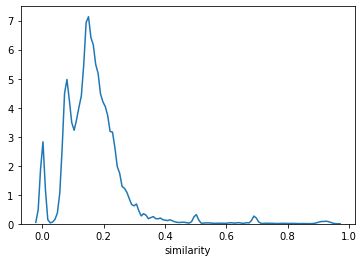

In [31]:
#per i not in uso la damerau levenshtein distance
awards_api_notIn['similarity'] =  [
    textdistance.damerau_levenshtein.normalized_similarity(x[1],x[0]) for x in zip(
        awards_api_notIn['name_cleaned'], awards_api_notIn['name_cleaned_int']
    )]

#istogramma della distribuzione
from seaborn import distplot
distplot(awards_api_notIn['similarity'], bins = [0,.2,.4,.6,.8,1], hist = False)

In [32]:
#ranking per livello di similarita
awards_api_notIn['order'] = awards_api_notIn.groupby("id")["similarity"].rank(method="first", ascending=False)

In [33]:
#prendo quelli con similarita piu alta ma solo se hanno punteggio >=.6
awards_api_founded_hasName_sim = awards_api_notIn.copy()[(awards_api_notIn['order'] == 1) &
                                                        (awards_api_notIn['similarity'] >= .6)]
awards_api_founded_hasName_sim['int_source'] = 'api_sim'
awards_api_founded_hasName_sim.head()

,award_id,person,title_id,source,id,name_cleaned,person_id,name_cleaned_int,popularity,similarity,order,int_source
0,aw-24422,LLOYD HAINES,tv-3674,tv,78,LLOYDHAINES,p-105597,LLOYDHAYNES,1.131,0.909091,1.0,api_sim
3,aw-23937,HERVE VILLECHAIZE,tv-37812,tv,427,HERVEVILLECHAIZE,p-9322,HERVVILLECHAIZE,2.023,0.937500,1.0,api_sim
7,aw-23442,DANA DELANEY,tv-2225,tv,798,DANADELANEY,p-53783,DANADELANY,4.790,0.909091,1.0,api_sim
9,aw-23385,DANA DELANEY,tv-2225,tv,837,DANADELANEY,p-53783,DANADELANY,4.790,0.909091,1.0,api_sim
10,aw-23382,RICKY/RICK SCHRODER,m-107195,tv,840,RICKYRICKSCHRODER,p-63525,RICKYSCHRODER,2.130,0.764706,1.0,api_sim


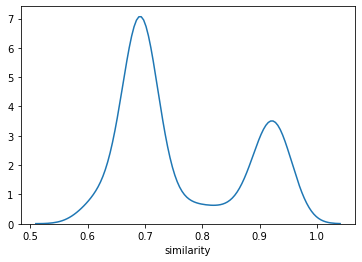

In [34]:
#istogramma della distribuzione dei trovati
from seaborn import distplot
distplot(awards_api_founded_hasName_sim['similarity'], bins = [0,.2,.4,.6,.8,1], hist = False)

In [35]:
#estrazione dei non trovati
awards_api_not_founded_sim = awards_api_notIn.copy()[
    [True if id_ not in awards_api_founded_hasName_sim['id'].tolist() else False for id_ in awards_api_notIn['id'].tolist()]
]

In [36]:
print('Trovati: ' + str(len(awards_api_founded_hasName_sim.id.unique())))
print('Non trovati: ' + str(len(awards_api_not_founded_sim.id.unique())))

Trovati: 834
Non trovati: 2870


In [37]:
awards_api_not_founded_sim.sort_values('similarity', ascending = False)

,award_id,person,title_id,source,id,name_cleaned,person_id,name_cleaned_int,popularity,similarity,order
16359,aw-20563,PATRICK SCHMEDEMAN,tv-39673,tv,8010,PATRICKSCHMEDEMAN,p-1113047,DIANASCHMEDEMAN,0.600,0.588235,1.0
27247,aw-20832,CHRIS MCSHANE,None,tv,20037,CHRISMCSHANE,p-6350,IANMCSHANE,4.769,0.583333,1.0
35832,aw-6854,DAVID M. MASSEY,m-141316,movies,25468,DAVIDMMASSEY,p-853898,ANNAMASSEY,0.600,0.583333,2.0
12922,aw-20607,JOSHUA FIROSZ,tv-1459,tv,7364,JOSHUAFIROSZ,p-332317,JOSHFIGGS,0.600,0.583333,1.0
22458,aw-18773,PHILIP MARLOW,m-101924,tv,10775,PHILIPMARLOW,p-1491886,PHILIPRCRAIG,0.600,0.583333,2.0
...,...,...,...,...,...,...,...,...,...,...,...
59591,aw-12170,BIZET'S CARMEN,m-12809,movies,36421,BIZETSCARMEN,p-457673,SHIRLEYYEUNG,2.337,0.000000,60.0
59583,aw-12170,BIZET'S CARMEN,m-12809,movies,36421,BIZETSCARMEN,p-26485,MARADEDEUS,3.592,0.000000,59.0
145636,aw-1535,THOMAS T. MOULTON,m-32325,movies,34337,THOMASTMOULTON,p-24978,IRADEANJAGGER,3.781,0.000000,63.0
145632,aw-1535,THOMAS T. MOULTON,m-32325,movies,34337,THOMASTMOULTON,p-11228,FARLEYGRANGER,2.080,0.000000,62.0


In [38]:
all_awards_founded = pd.concat([
    awards_name_founded,
    awards_nameCleaned_founded[['award_id', 'person', 'title_id', 'source', 'id', 'person_id', 'popularity','int_source']],
    awards_api_isIn[['award_id', 'person', 'title_id', 'source', 'id', 'person_id', 'popularity','int_source']],
    awards_api_founded_hasName_sim[['award_id', 'person', 'title_id', 'source', 'id', 'person_id', 'popularity','int_source']]
])
#all_awards_notFounded = 

In [39]:
#riordino per popolarita decrescente e poi elimino i duplicati:
#con keep = first di default elimino dal secondo in poi, ossia tengo quelli con popolarita piu alta
all_awards_founded_maxPop = all_awards_founded.sort_values(
    ['id','popularity'], axis = 0, ascending = False
).drop_duplicates(['id']).sort_values(
    ['award_id','title_id', 'person_id','popularity'], axis = 0, ascending = False
).drop_duplicates(['award_id','title_id', 'person_id'])

In [40]:
print('Trovati correttamente: ' + str(all_awards_founded_maxPop.shape[0]))
print('Trovati dubbi in quanto nome troppo diverso: ' + str(len(awards_api_not_founded_sim.id.unique())))
print('Non trovati: ' + str(awards_cast_crew_notFounded.shape[0]))
print('Premi totali: ' + str(awards.shape[0]))

Trovati correttamente: 35878
Trovati dubbi in quanto nome troppo diverso: 2870
Non trovati: 54
Premi totali: 38854


In [41]:
all_awards[['award', 'award_id', 'award_type', 'is_winner', 'person', 'title_id', 'year']].merge(
    all_awards_founded_maxPop[[ 'person_id', 'award_id']],
    on = 'award_id').to_pickle(path_data + 'awards/integrated/award_people_final.df')